In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [3]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

In [4]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 30.6 MB/s eta 0:00:00
/content/drive/MyDrive/Colab Notebooks


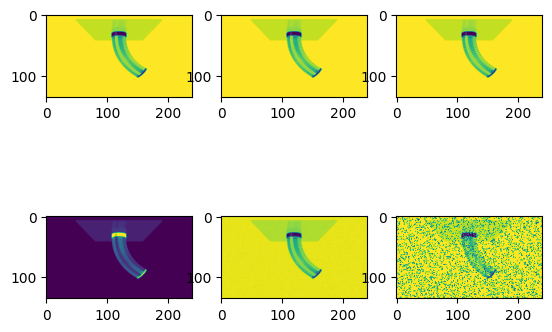

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


(513, 135, 240, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


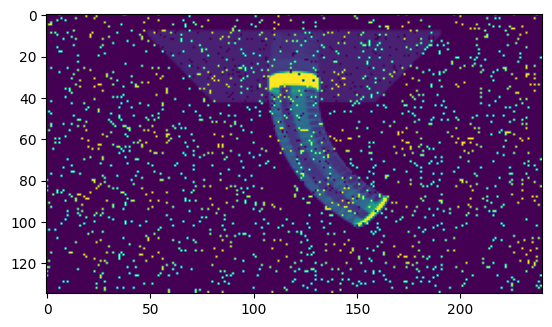

In [5]:
%run DataAugmentation.ipynb

### Offline Data Augmentation

In [12]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = get_augmented_dataset(
    force_resize=False, rescale_coordinates=100, train_perc=0.6,
    eval_perc=0.2, test_perc=0.2, **augmentation_configuration,
  )

In [6]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [7]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 135, 240, 8)       392       
                                                                 
 conv2d_1 (Conv2D)           (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 120, 8)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 67, 120, 16)       2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 60, 16)       0         
 2D)                                                  

In [13]:
print(len(train_images), len(train_tip_pos))

1842 1842


In [14]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
58/58 [==============================] - 16s 34ms/step - loss: 69.1005 - mean_absolute_error: 6.6037 - mean_euclidean_error: 13.4033 - val_loss: 46.1650 - val_mean_absolute_error: 5.6309 - val_mean_euclidean_error: 11.2886
Epoch 2/100
58/58 [==============================] - 1s 14ms/step - loss: 41.6257 - mean_absolute_error: 5.1682 - mean_euclidean_error: 10.6319 - val_loss: 45.7545 - val_mean_absolute_error: 5.5995 - val_mean_euclidean_error: 11.2027
Epoch 3/100
58/58 [==============================] - 1s 14ms/step - loss: 40.7099 - mean_absolute_error: 5.0880 - mean_euclidean_error: 10.5056 - val_loss: 46.8725 - val_mean_absolute_error: 5.6174 - val_mean_euclidean_error: 11.2084
Epoch 4/100
58/58 [==============================] - 1s 14ms/step - loss: 40.7300 - mean_absolute_error: 5.1017 - mean_euclidean_error: 10.5092 - val_loss: 48.6564 - val_mean_absolute_error: 5.8869 - val_mean_euclidean_error: 11.7964
Epoch 5/100
58/58 [==============================] - 1s 14ms/st

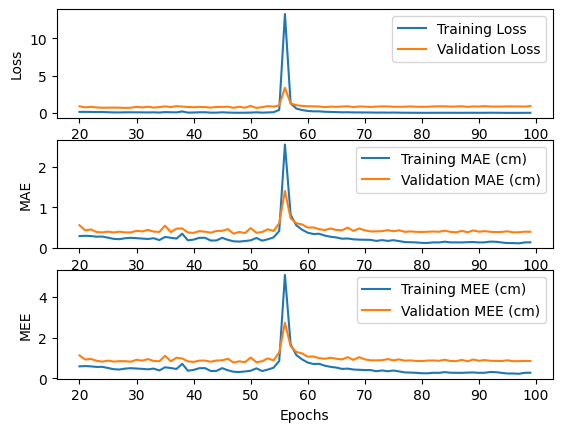

In [15]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 6ms/step
103 103 103
103 103 103
x-axis: mean = 0.5630658352013738, std = 2.921638938191559
y-axis: mean = 0.06746653592372125, std = 0.2093356831138096
z-axis: mean = 0.015771645695355378, std = 0.029632917151765675


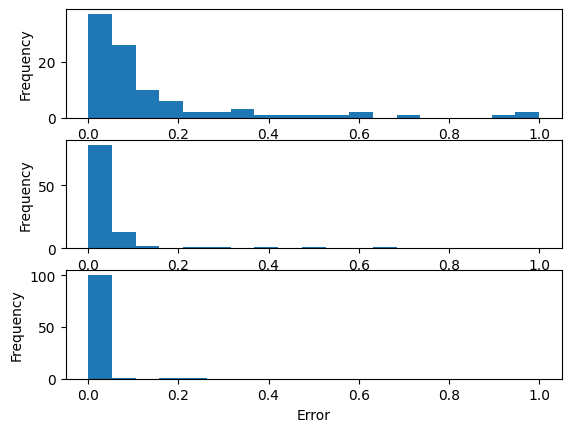

In [16]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [17]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.3939186632633209
Std of MAE: 0.63092440366745
Mean of MEE: 0.8517235682146526
Std of MEE: 1.4381319531512136


We calculate them also along each axis:

In [18]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.72822426 0.20946987 0.24406197]
Std of Distance along axes: [1.41266562 0.26932986 0.30288512]


Now we save model and history:

In [19]:
model.save('offlineDataAugmentedBaseVGG')

In [20]:
json.dump(history.history, open('offlineDataAugmentedBaseVGG.json', 'w'))

In [21]:
del model

### Online Data Augmentation

#### VGG19

In [12]:
images, tip_pos = get_dataset(force_resize=False, rescale_coordinates=100)

(train_images, train_tip_pos), (eval_images, eval_tip_pos), \
  (test_images, test_tip_pos) = holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [13]:
online_augmentation_configuration = {
    'apply_brightness_change': {'factor': 0.1},
    'apply_saturation_change': {'factor': 1},
    #'apply_inversion': {},
    'apply_gaussian_noise': {'stddev': 0.1},
    'apply_salt_and_pepper': {'ratio': 0.1}
}
data_augmenter = get_data_augmentation_layer(**online_augmentation_configuration)

In [19]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(135,240, 3)),
  data_augmenter,

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [20]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 135, 240, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 135, 240, 8)       392       
                                                                 
 conv2d_21 (Conv2D)          (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 67, 120, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 67, 120, 16)       2064      
                                                                 
 conv2d_23 (Conv2D)          (None, 67, 120, 16)       4112      
                                                      

In [22]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 5s 54ms/step - loss: 225557888.0000 - mean_absolute_error: 2176.5471 - mean_euclidean_error: 5041.7065 - val_loss: 61.9680 - val_mean_absolute_error: 6.8097 - val_mean_euclidean_error: 13.5148
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 96.4493 - mean_absolute_error: 8.0460 - mean_euclidean_error: 15.9760 - val_loss: 60.5667 - val_mean_absolute_error: 6.3952 - val_mean_euclidean_error: 12.9329
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 48.5350 - mean_absolute_error: 5.7171 - mean_euclidean_error: 11.4372 - val_loss: 46.8346 - val_mean_absolute_error: 5.6814 - val_mean_euclidean_error: 11.1810
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 43.4785 - mean_absolute_error: 5.3526 - mean_euclidean_error: 10.8758 - val_loss: 47.6631 - val_mean_absolute_error: 5.7160 - val_mean_euclidean_error: 11.2518
Epoch 5/100
10/10 [==============================] -

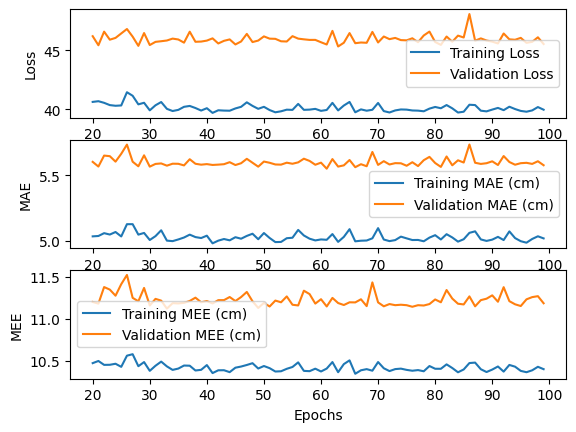

In [23]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 6ms/step
103 103 103
103 103 103
x-axis: mean = 1.1773958616073987, std = 0.9274882837090708
y-axis: mean = 1.064161082206498, std = 0.38620110145520586
z-axis: mean = 0.19882560447252032, std = 0.1883187471725195


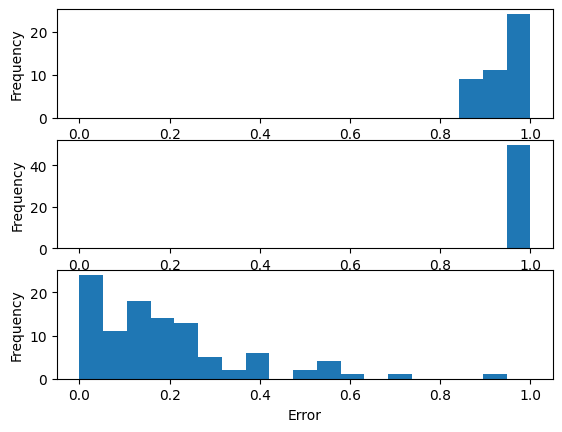

In [24]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [25]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 5.576818466186523
Std of MAE: 1.8639721870422363
Mean of MEE: 11.187611623692261
Std of MEE: 3.3891885575976097


We calculate them also along each axis:

In [26]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [6.39389907 7.05148943 3.2850631 ]
Std of Distance along axes: [3.79173637 3.92864278 2.33252354]


Now we save model and history:

In [27]:
model.save('onlineDataAugmentedBasicVGG19')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [28]:
json.dump(history.history, open('onlineDataAugmentedBasicVGG19.json', 'w'))

In [29]:
del model